In [48]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

ASK:

Será que é possível indicar cervejas que o usuário vai gostar, sabendo as que ele ja experimentou, assim melhorando sua experiência futura com base em experiências passadas?

GET:

Para sanar essa dúvida precisamos de dados... Para isso, fomos a busca e encontramos algo interessante

No kaggle achamos esse conjunto de dados: https://www.kaggle.com/datasets/rdoume/beerreviews?select=beer_reviews.csv

e a partir dele vamos explorar para buscar entender os dados e como eles podem nos ajudar a modelar a nossa solução

EXPLORE:

In [49]:
df = pd.read_csv('beer_reviews.csv')

In [50]:
df

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586609,14359,The Defiant Brewing Company,1162684892,5.0,4.0,3.5,maddogruss,Pumpkin Ale,4.0,4.0,The Horseman's Ale,5.2,33061
1586610,14359,The Defiant Brewing Company,1161048566,4.0,5.0,2.5,yelterdow,Pumpkin Ale,2.0,4.0,The Horseman's Ale,5.2,33061
1586611,14359,The Defiant Brewing Company,1160702513,4.5,3.5,3.0,TongoRad,Pumpkin Ale,3.5,4.0,The Horseman's Ale,5.2,33061
1586612,14359,The Defiant Brewing Company,1160023044,4.0,4.5,4.5,dherling,Pumpkin Ale,4.5,4.5,The Horseman's Ale,5.2,33061


In [51]:
df.shape

(1586614, 13)

Uau, temos aqui mais de um milhão de registros e também 13 'features' que descrevem nossos dados, mas vamos aqui buscar entender o que são esses dados, de que forma são relevantes para nós, e como podemos manipulálos

Será que existem valores nulos?

In [52]:
nulos_por_coluna = df.isnull().sum()

# Exibir o número de valores nulos por coluna
print("Quantidade de valores nulos por coluna:")
print(nulos_por_coluna)

Quantidade de valores nulos por coluna:
brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64


Temos poucos nulos para um dataset de um milhão e meio. Mas para esses nulos no abv, será que conseguimos preencher, caso o abv de uma dessas cervejas ja tenha sido preenchida?

In [53]:
valores_abv_por_id = df.dropna(subset=['beer_abv']).set_index('beer_beerid')['beer_abv'].to_dict()

df['beer_abv'] = df.apply(lambda row: valores_abv_por_id.get(row['beer_beerid'], row['beer_abv']), axis=1)

In [54]:
nulo_abv = df['beer_abv'].isnull().sum()

print(nulo_abv)

67785


A resposta é não rs.

Como estamos trabalhando com um sistema de recomendação, o usuário que avaliou é bastante importante para nós. e já que temos muitos dados, iremos excluir as linhas com nulo nesse campo

In [55]:
df = df.dropna(subset=['review_profilename'])


Dicionário:


Brewery id: é um identificador único atribuído a cada cervejaria listada no conjunto de dados

brewery name: é o nome da cervejaria

Review time: provavelmente se refere ao momento em que uma avaliação ou revisão específica de uma cerveja foi registrada. Porém parece estar codificado.

Review Overall: pontuação geral ou avaliação geral dada a uma cerveja específica por um revisor

Review aroma: Assim como o review overall, é uma coluna subjetiva e trata da nota atribuida ao aroma de cada cerveja.

Review appareance: Subjetiva e trata a respeito da aparência visual

Review profile name: Essa coluna descre o nome de usuario daquele revisor, ou seja para aquela aquela cerveja, com aquelas notas, quem atribuiu.

Beer_Style: categorização do tipo ou estilo específico de cerveja que está sendo avaliada ou descrita. Cada cerveja pode ser classificada em um estilo com base em suas características de sabor, aroma, aparência, ingredientes e outros atributos distintivos. Temos alguns estilos como IPA, PILSEN...

Review taste: pontuação atribuída à sensação na boca de uma cerveja específica por um revisor

Beer name: Nome da cerveja

beer abv: Alcoól por volume

beer id: id de cada cerveja

Com essa descrição e entendimento é natural que surjam algumas dúvidas. Por exemplo, será que essa coluna de review time realmente pode ser convertida?

In [56]:
datas = df['review_time']
datas

0          1234817823
1          1235915097
2          1235916604
3          1234725145
4          1293735206
              ...    
1586609    1162684892
1586610    1161048566
1586611    1160702513
1586612    1160023044
1586613    1160005319
Name: review_time, Length: 1586266, dtype: int64

Para isso, após algumas pesquisas vimos que pode estar em padrão unix. E vamos tentar convertê-las

In [57]:
ndt = []
for data in datas:
    dt_object = datetime.datetime.fromtimestamp(data)
    formatted_date = dt_object.strftime('%Y-%m-%d %H:%M:%S')

    ndt.append(formatted_date)

dt = {'Data review': ndt}
df_dt = pd.DataFrame(dt)

In [58]:
df_dt

,Data review
0,2009-02-16 17:57:03
1,2009-03-01 10:44:57
2,2009-03-01 11:10:04
3,2009-02-15 16:12:25
4,2010-12-30 15:53:26
...,...
1586261,2006-11-04 21:01:32
1586262,2006-10-16 22:29:26
1586263,2006-10-12 22:21:53
1586264,2006-10-05 01:37:24


Uau, então realmente é possivél converter aquela coluna em data, mas deixaremos daquele jeito por enquanto

In [59]:
#Quantas cervejas temos no dataset?

qtd_cervejas = df['beer_beerid'].nunique()
print(qtd_cervejas)

66051


Não sabia que existiam tantas cervejas assim rs

Para as outras colunas de review, sabemos que são subjetivas, mas para cada uma delas, qual será que é o intervalo

In [60]:
review_colunms = ['review_overall','review_aroma', 'review_appearance', 'review_palate', 'review_taste' ]

In [61]:
for c in review_colunms:
    print(c, df[c].min(), ' - ',df[c].max())

review_overall 0.0  -  5.0
review_aroma 1.0  -  5.0
review_appearance 0.0  -  5.0
review_palate 1.0  -  5.0
review_taste 1.0  -  5.0


Parece que estão estabelecidos valores de 0 a 5 para todas colunas, embora sejam subjetivas temos intervalos bem definidos

Como será que essas notas se distribuem para cada review? Será que temos uma distribuição normal das coisas, ou temos a maioria das cervejas proximas de 5 e vice-versa?

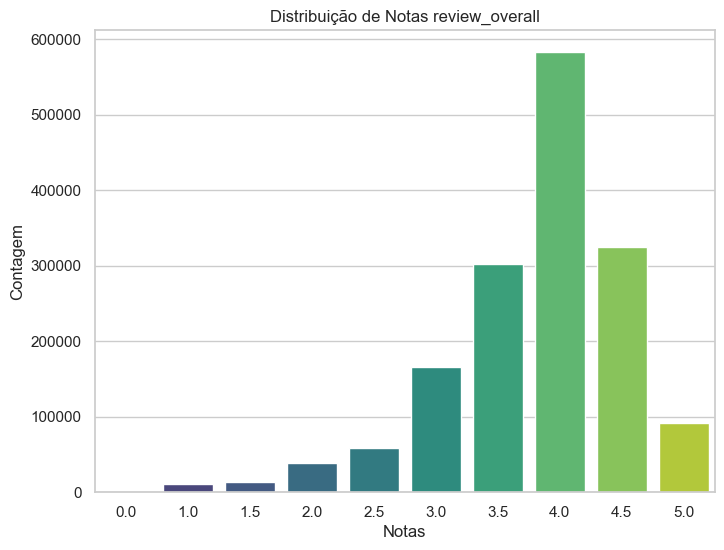

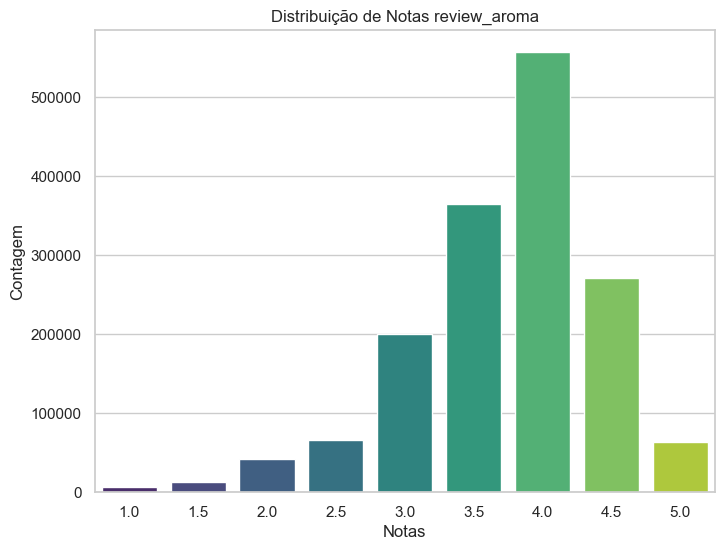

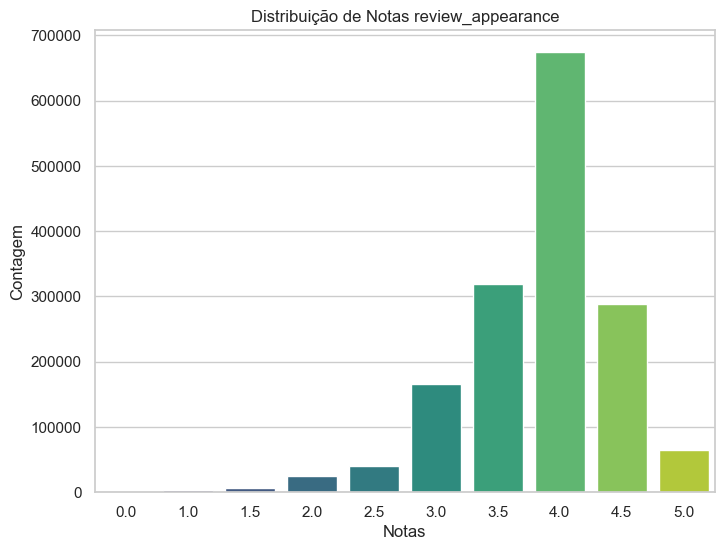

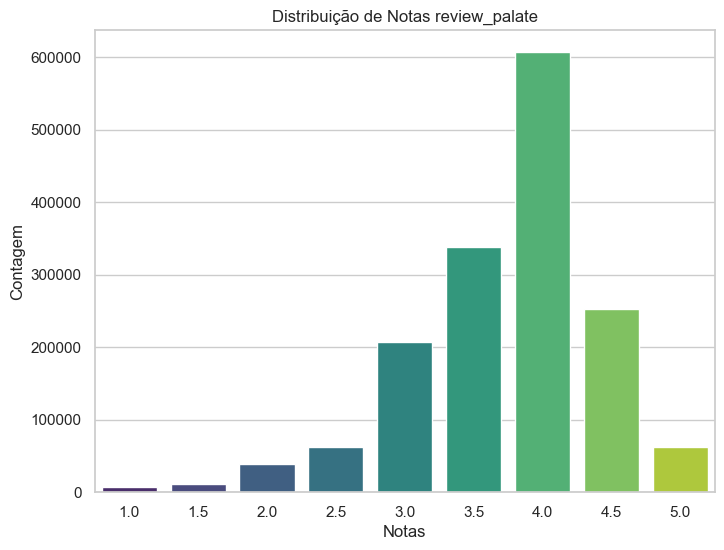

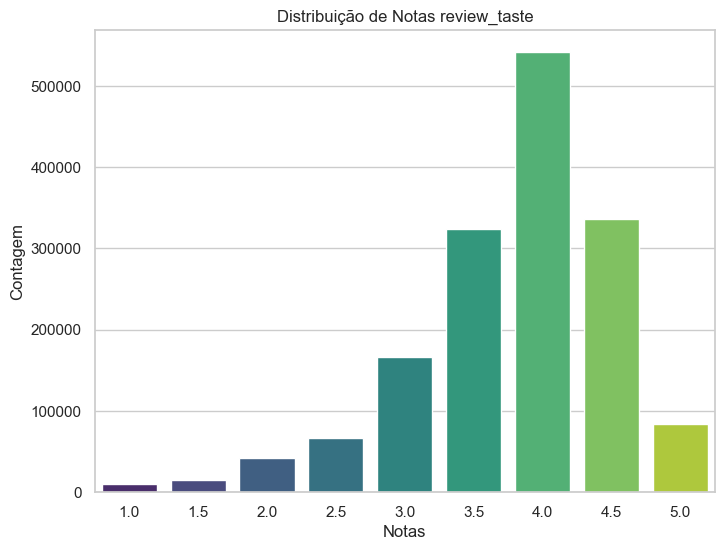

In [62]:
for c in review_colunms:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=df[c], palette="viridis")

    # Adicionar título e rótulos dos eixos
    plt.title(f"Distribuição de Notas {c}")
    plt.xlabel("Notas")
    plt.ylabel("Contagem")

    # Exibir o gráfico
    plt.show()

In [63]:
import scipy.stats as stats
# Realizar o teste de normalidade de Shapiro-Wilk

for c in review_colunms:
    print(df[c].mean(), df[c].median())

3.8156280220341356 4.0
3.735685565976955 4.0
3.84167125816225 4.0
3.7437532544982997 4.0
3.7929209224682365 4.0


Vemos aqui, que predominantemente temos os dados 'ao redor' do valor 4.

Será que mesmo para valores tão proximos, temos a notas baixas como "outliers"?

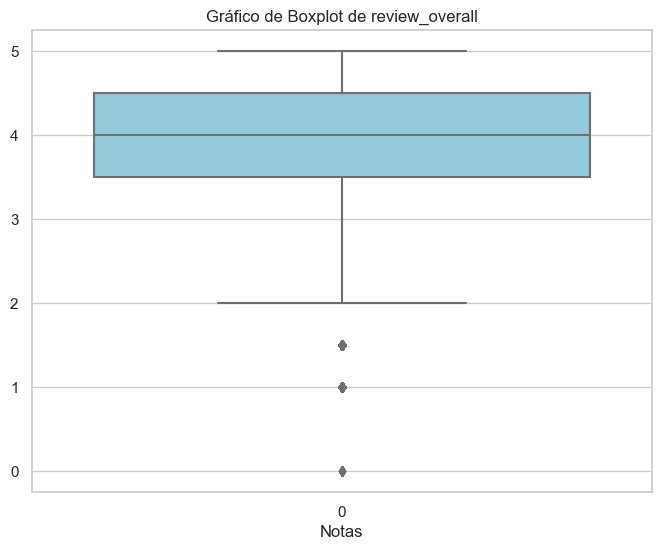

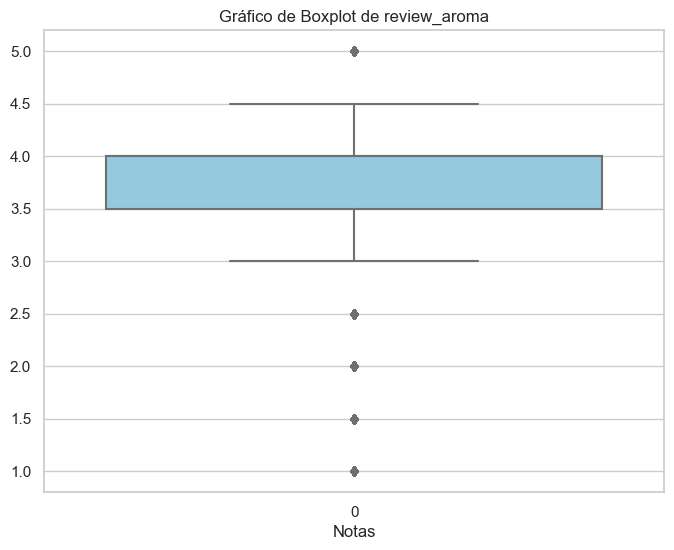

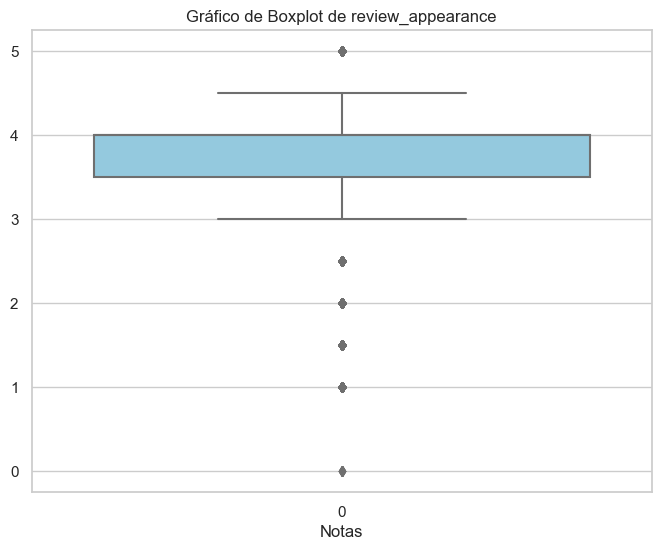

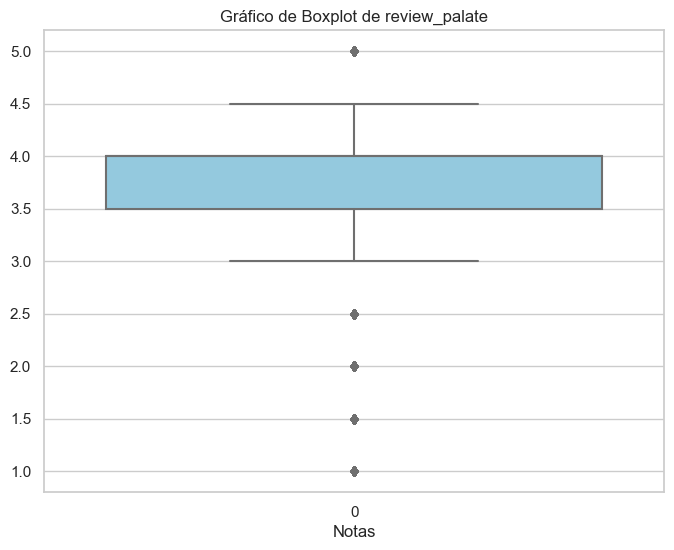

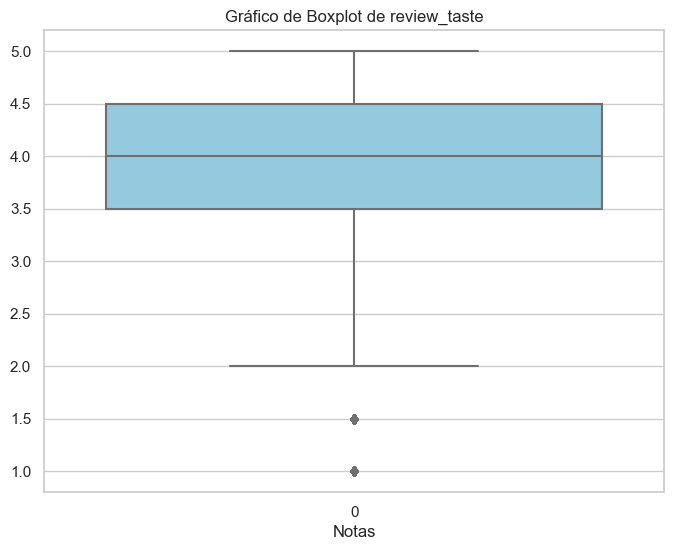

In [64]:
for c in review_colunms:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df[c], color='skyblue')

    # Adicionar título e rótulo do eixo x
    plt.title(f"Gráfico de Boxplot de {c}")
    plt.xlabel("Notas")

    # Exibir o gráfico
    plt.show()

Uau, com esses gráficos conseguimos ver que algumas notas, mesmo que dentro do domínio do problema são consideradas anomalias

O estilo de cerveja pode nos trazer algumas informações interessantes não contidas no dataset. Vamos analisar

In [65]:
df['beer_style'].nunique()

104

In [86]:
estilos_unicos = df['beer_style'].unique()

# Exibir a lista de estilos de cerveja únicos
for estilo in estilos_unicos:
    print(estilo)

Hefeweizen
English Strong Ale
Foreign / Export Stout
German Pilsener
American Double / Imperial IPA
Herbed / Spiced Beer
Light Lager
Oatmeal Stout
American Pale Lager
Rauchbier
American Pale Ale (APA)
American Porter
Belgian Strong Dark Ale
American IPA
American Stout
Russian Imperial Stout
American Amber / Red Ale
American Strong Ale
Märzen / Oktoberfest
American Adjunct Lager
American Blonde Ale
Euro Pale Lager
English Brown Ale
Scotch Ale / Wee Heavy
Fruit / Vegetable Beer
American Double / Imperial Stout
Belgian Pale Ale
English Bitter
English Porter
Irish Dry Stout
American Barleywine
Belgian Strong Pale Ale
Doppelbock
Maibock / Helles Bock
Pumpkin Ale
Dortmunder / Export Lager
Euro Strong Lager
Euro Dark Lager
Low Alcohol Beer
Weizenbock
Extra Special / Strong Bitter (ESB)
Bock
English India Pale Ale (IPA)
Altbier
Kölsch
Munich Dunkel Lager
Rye Beer
American Pale Wheat Ale
Milk / Sweet Stout
Schwarzbier
Vienna Lager
American Amber / Red Lager
Scottish Ale
Witbier
American Black A

Vamos carregar um dataset com o estilo e uma taxa de ibu (indicador de amargor)

In [106]:
estilos = pd.read_csv('saida.csv')
estilos

,beer_style,ibu_min,ibu_max
0,Altbier,25.0,50.0
1,Amber Kellerbier,25.0,40.0
2,American Amber Ale,25.0,40.0
3,American Barleywine,50.0,100.0
4,American Brown Ale,20.0,30.0
...,...,...,...
192,Berliner Weissbier,7.0,7.0
193,Kvass,12.0,12.0
194,Faro,10.0,10.0
195,Happoshu,11.0,11.0


In [107]:
valores_df1 = df['beer_style'].unique()

# Obter os valores únicos da coluna 'coluna_igual' no segundo DataFrame
valores_df2 = estilos['beer_style'].unique()

# Identificar quais valores estão em valores_df1 e não estão em valores_df2
valores_nao_em_df2 = [valor for valor in valores_df1 if valor not in valores_df2]
print(len(valores_nao_em_df2))
for valor in valores_nao_em_df2:
    print(valor)

0


Bom ressaltar que inicialmente esse número não era 0, foi feito uma coleta de dados para que podessemos saber o ibu de cada cerveja. Agora vamos inserir essas informações no dataset

In [109]:
df = pd.merge(df, estilos, on='beer_style')

df

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,ibu_min,ibu_max
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986,10.0,15.0
1,9020,Yazoo Brewing Company,1224350360,4.0,4.0,3.0,Likeburning,Hefeweizen,4.0,3.5,Hefeweizen,5.0,20575,10.0,15.0
2,1454,Broad Ripple Brew Pub,1316545215,4.0,3.5,3.0,JamesS,Hefeweizen,4.0,4.5,Hefe Weizen,4.5,73291,10.0,15.0
3,850,Moon River Brewing Company,1133896338,3.5,3.5,3.0,GusterFan,Hefeweizen,3.0,3.5,Wheezy Heifer,5.5,27229,10.0,15.0
4,850,Moon River Brewing Company,1193191936,4.0,4.0,3.5,harpo111,Hefeweizen,3.5,3.5,Hefe-Weizen,5.5,2776,10.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586261,2807,Microbrasserie Charlevoix,1288562807,4.5,4.0,4.0,MasterSki,Bière de Champagne / Bière Brut,4.5,4.0,Dominus Vobiscum Brut,11.0,59014,40.0,40.0
1586262,2807,Microbrasserie Charlevoix,1288546131,4.0,4.0,3.5,jrallen34,Bière de Champagne / Bière Brut,4.5,4.0,Dominus Vobiscum Brut,11.0,59014,40.0,40.0
1586263,2807,Microbrasserie Charlevoix,1281632126,4.0,4.0,5.0,Phyl21ca,Bière de Champagne / Bière Brut,4.0,4.0,Dominus Vobiscum Brut,11.0,59014,40.0,40.0
1586264,2807,Microbrasserie Charlevoix,1279650183,5.0,4.0,4.5,wordemupg,Bière de Champagne / Bière Brut,4.5,4.5,Dominus Vobiscum Brut,11.0,59014,40.0,40.0
